_____________________
<h3><b>3. Visual search with k-NN</b></h3>

___________________

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import tensorflow as tf #tf version is 1.12
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#import data
 with np.load('features_mobilenet_v2.npz', allow_pickle=False) as npz_file:
    #features
    X_train = npz_file['train_hl']
    X_val = npz_file['validation_hl']
    X_test = npz_file['test_hl']
    #labels
    y_train = npz_file['labels_train']
    y_val = npz_file['labels_validation']
    y_test = npz_file['labels_test']
    #imgs
    train_imgs = npz_file['train_imgs']
    validation_imgs = npz_file['validation_imgs']
    test_imgs = npz_file['test_imgs']

________________
><h5><b>3.1. Fit and tune the model</b></h5>

_____________

In [3]:
#Fit on valisation set
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()), #data are standardized
    ('knn', KNeighborsClassifier(n_neighbors=3))])

# Fit estimator
knn_pipe.fit(X_train, y_train);

In [4]:
#Tune the results (fit on train and test on validation)

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=5)]

# store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_train, y_train)

    # Save model and its performance on train/validation sets
    gs_results.append({
        'k': k,
        'train_accuracy': knn_pipe.score(X_train, y_train),
        'validation_accuracy': knn_pipe.score(X_val, y_val)
    })

# view dataframe
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='validation_accuracy', ascending=False).head()

,k,train_accuracy,validation_accuracy
1,5,0.917857,0.892086
2,10,0.885714,0.877698
0,1,1.000000,0.863309
4,20,0.871429,0.856115
3,15,0.864286,0.848921


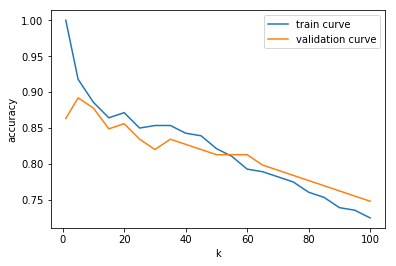

validation min= 0.75
validation max= 0.89
best k= 5


In [5]:
#plot the validation curve
plt.plot(gs_results['k'], gs_results['train_accuracy'], label='train curve')
plt.plot(gs_results['k'], gs_results['validation_accuracy'], label='validation curve')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

#min/max accury validation
print('validation min=', round(gs_results['validation_accuracy'].min(), 2))
print('validation max=', round(gs_results['validation_accuracy'].max(), 2))
print('best k=', gs_results.loc[gs_results['validation_accuracy'].idxmax(), 'k'])

In [6]:
# Tuned k-NN estimator
tuned_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

tuned_knn.fit(X_train, y_train)

# Evaluate on test set
accuracy_test_knn = tuned_knn.score(X_test, y_test)
print('test accuracy K-nn = {:.2f}%'.format(accuracy_test_knn))

test accuracy K-nn = 0.96%


In [7]:
#Store the accuracy in pd and export csv
models_summary = {'model': ['k-nn'],
                  'test_accuracy': [accuracy_test_knn]}
models_summary = pd.DataFrame(models_summary)
models_summary.to_csv ('models_summary.csv', index=False)

________________
><h5><b>3.2. Search engine</b></h5>

_____________

Pick an image from the test set and plot its 10 nearest neighbors from the train set

In [8]:
# define the pipeline steps
scaler = tuned_knn.named_steps['scaler']
knn = tuned_knn.named_steps['knn']

# new preprocessing pipeline
preprocessing_pipeline = Pipeline(tuned_knn.steps[:-1])

X_preprocessed = preprocessing_pipeline.transform(X_test)

#extract neighbors and distances
neighbors=knn.kneighbors(X_preprocessed, n_neighbors=10, return_distance=True)#result in a tuple with distances and indexes

#separate distances and indexes
distances, indexes = neighbors

print('distances:', distances.shape, 'indexes:', indexes.shape)

distances: (50, 10) indexes: (50, 10)


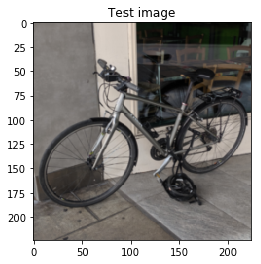

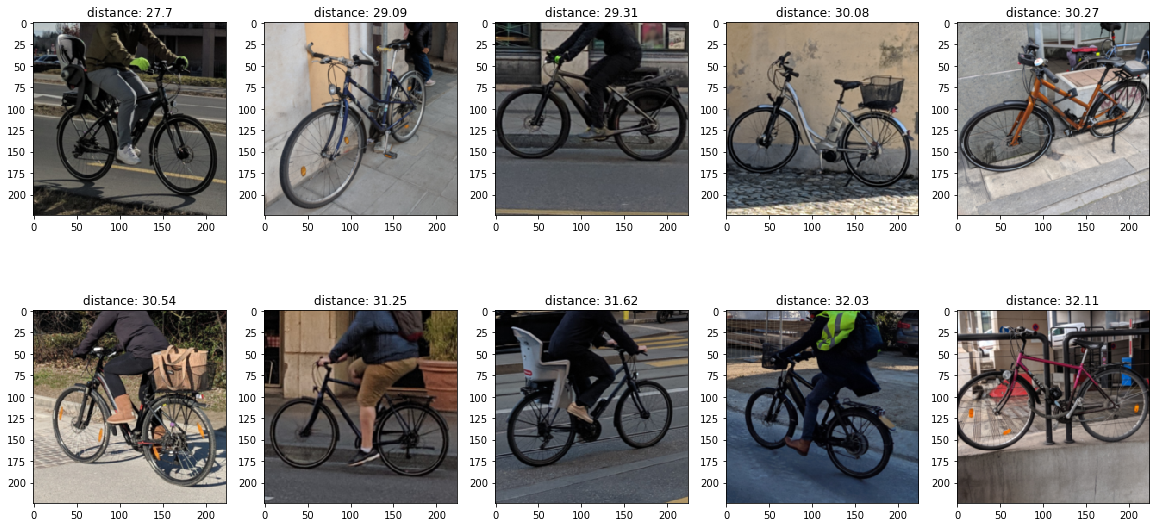

In [9]:
#the logic here is to define a number (x) which will be used for the following purposes:
#select the image in the test set 'test_imgs[x]'
#use the indexes in the position [x] to retrieve the images from train_imgs (train_neighbors) 
#use distances in the position [x] to retrieve the corresponding distance (distances_taker)

#define the test image index you wanto to see (range: 0-49)
x=0

#plot test image
image = test_imgs[x]
plt.imshow(image)
plt.title('Test image')
plt.show()

#10 neighbors images
#extract indexes from train set
indexes_taker = indexes[x]
train_neighbors = np.take(train_imgs, indexes_taker, axis=0)#here I use np.take to filter the images based on the defined (x) in the train_imgs (i.e. it retuns a 4d array 10,224,224,3)

#extract distances with the same method (np.take)
distances_taker = distances[x]

plt.figure(figsize=(20, 20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
for i in range(0,10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(train_neighbors[i])
    plt.title(f'distance: {round(distances_taker[i], 2)}')